In [79]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
N = 30
noise_std = 2
x_spread = 5

x = np.random.randn(N) * x_spread
w, b = np.random.randn(2) * noise_std
y = w*x + b + np.random.randn(N) * noise_std

In [3]:
print("w: {w:.2f}, b: {b:.2f}".format(w=w, b=b))

w: 0.90, b: -1.69


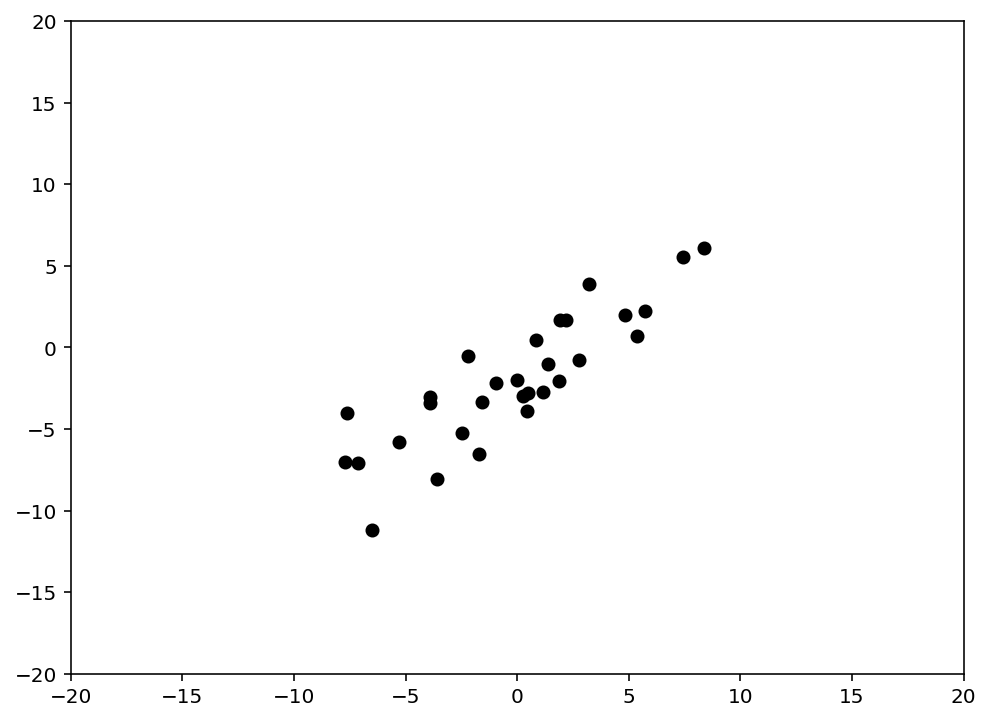

In [82]:
plt.figure(figsize=(8,6))
plt.plot(x, y, 'ko');
plt.xlim(-20, 20);
plt.ylim(-20, 20);

In [51]:
tf.reset_default_graph()

In [55]:
# Data placeholders
x_ = tf.placeholder(tf.float32, shape=[None], name='x')
y_ = tf.placeholder(tf.float32, shape=[None], name='y')

In [56]:
i = 0

In [57]:
# Model
with_initializer = False
i += 1
i_ = str(i)

with tf.variable_scope("full_model") as full_model:
    if with_initializer:
        loc_params = [tf.get_variable('w_loc_init_' + i_, initializer=np.float32(w)), 
                      tf.get_variable('b_loc_init_' + i_, initializer=np.float32(b))]
    else:
         loc_params = [tf.get_variable('w_loc_' + i_, shape=[]), tf.get_variable('b_loc_' + i_, shape=[])]       
    scale_params = [tf.get_variable('w_scale_' + i_, shape=[]), tf.get_variable('b_scale_' + i_, shape=[])]

In [58]:
def generate_sample(n_z_samples=1):
    z_sample = tf.random_normal([n_z_samples])
    w_gen = loc_params[0] + tf.log(1. + tf.exp(scale_params[0])) * z_sample
    b_gen = loc_params[1] + tf.log(1. + tf.exp(scale_params[1])) * z_sample
    return w_gen, b_gen

In [59]:
def duplicate_tensor(v, n_samples):
    return tf.transpose(tf.reshape(tf.tile(v, multiples=[n_samples]), [n_samples, tf.size(v)]))

def likelihood_prob(y, x, w_samples, b_samples):
    _, var = tf.nn.moments(y, axes=[0])
    likelihood = tf.contrib.distributions.Normal(
        loc=duplicate_tensor(x, tf.size(w_samples))*w_samples + b_samples, 
        scale= tf.tile(tf.reshape(tf.sqrt(var), [1]), [tf.size(w_samples)]))
    
    return likelihood.prob(duplicate_tensor(y, tf.size(w_samples)))

def elbo_loss(x, y, n_z_samples):
    w_gen, b_gen = generate_sample(n_z_samples)

    prior = tf.contrib.distributions.Normal(loc=[0., 0.], scale=[5., 5.])
    variational_distro = tf.contrib.distributions.Normal(
        loc=loc_params, scale=[tf.log(1. + tf.exp(p_scale)) for p_scale in scale_params])

    
    likelihood = likelihood_prob(y, x, w_gen, b_gen)
    log_likelihood = tf.reduce_mean(tf.reduce_sum(tf.log(likelihood), axis=1))
    kl = tf.reduce_mean(tf.contrib.distributions.kl_divergence(variational_distro, prior))
    elbo = kl - log_likelihood
    
    return elbo, kl, log_likelihood

In [60]:
loss, kl, likelihood = elbo_loss(x_, y_, n_z_samples=20)
train_op = tf.train.GradientDescentOptimizer(learning_rate=1e-2).minimize(loss)

## Training

In [72]:
indices = np.arange(N)
total_epochs = 200

In [73]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('../graphs/bayes_by_backprop', sess.graph)
    
    for epoch in range(total_epochs):
        samples = np.random.choice(indices, 30)
        
        _, train_loss, lik, train_kl = sess.run(
            [train_op, loss, likelihood, kl], feed_dict={x_: x[samples], y_: y[samples]})
        
        if epoch % int(total_epochs/30) == 0:
            print("Epoch - {i}/{n} - Loss: {loss:.3f}, Likelihood: {lik:.3f}, KL: {kl:.3f}".format(
                loss=train_loss, i=epoch, n=total_epochs, lik=lik, kl=train_kl))
            
    w_pred, b_pred = sess.run(loc_params)
    writer.close()

Epoch - 0/200 - Loss: 72.484, Likelihood: -70.645, KL: 1.840
Epoch - 6/200 - Loss: 55.926, Likelihood: -54.048, KL: 1.878
Epoch - 12/200 - Loss: 55.394, Likelihood: -53.495, KL: 1.898
Epoch - 18/200 - Loss: 54.593, Likelihood: -52.682, KL: 1.912
Epoch - 24/200 - Loss: 53.816, Likelihood: -51.880, KL: 1.936
Epoch - 30/200 - Loss: 53.261, Likelihood: -51.311, KL: 1.950
Epoch - 36/200 - Loss: 52.197, Likelihood: -50.212, KL: 1.985
Epoch - 42/200 - Loss: 53.779, Likelihood: -51.776, KL: 2.003
Epoch - 48/200 - Loss: 53.380, Likelihood: -51.359, KL: 2.021
Epoch - 54/200 - Loss: 50.457, Likelihood: -48.422, KL: 2.035
Epoch - 60/200 - Loss: 49.910, Likelihood: -47.865, KL: 2.046
Epoch - 66/200 - Loss: 52.613, Likelihood: -50.555, KL: 2.058
Epoch - 72/200 - Loss: 52.633, Likelihood: -50.550, KL: 2.083
Epoch - 78/200 - Loss: 52.596, Likelihood: -50.496, KL: 2.100
Epoch - 84/200 - Loss: 54.363, Likelihood: -52.250, KL: 2.113
Epoch - 90/200 - Loss: 53.848, Likelihood: -51.720, KL: 2.128
Epoch - 96

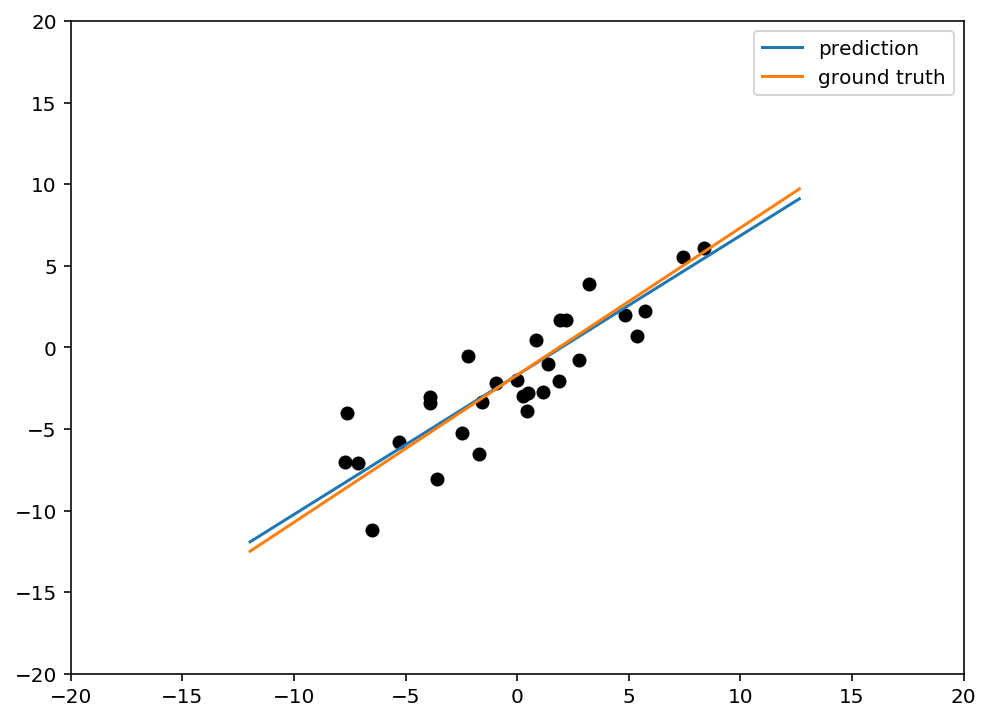

In [83]:
x_bound = np.array([np.min(x) - np.std(x), np.max(x) + np.std(x)])
plt.figure(figsize=(8,6))
plt.plot(x, y, 'ko');
plt.plot(x_bound, w_pred*x_bound + b_pred, label='prediction')
plt.plot(x_bound, w*x_bound+b, label='ground truth')
plt.xlim(-20, 20);
plt.ylim(-20, 20);
plt.legend();